# Classification of zircon CL images using convolutional neural networks

This Jupyter notebook is a supplmentary file to the manuscript entitled: Mineral texture classification using deep convolutional neural networks: an application to zircons from porphyry copper deposits by Chetan Nathwani et al.

This notebook contains code to:
* Segment images of individual crystals from mosaics of grain mounts
* Train a convolutional neural network to classify images from the Quellaveco porphyry copper deposits (including regularisation approaches)
* Apply transfer learning to the same classification task using the VGG-16 model trained on the ImageNet database

## Load packages and instantiate workbook

In [4]:
# This version has code that saves segmented images, which are manually inspected, and then re-imported
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import glob
import random as python_random
import sklearn.model_selection
from PIL import Image, ImageOps
import cv2
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

tf.keras.backend.clear_session()

# For reproducibility
np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(123)

## Segment images of individual crystals from input mosaics of grain mounts

In [ ]:
# Set directories
root_dir = 'C:/Users/chen/Desktop/Python_Projects/Zircon_Images/TIMA_Images'
save_dir = 'C:/Users/chen/Desktop/Python_Projects/Zircon_Images/Segmented_Images'
samples = []
x_train = []

# Import files
for filename in glob.iglob(root_dir + '**/*.png', recursive=True):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img)
    plt.show()
    canny = cv2.Canny(img, 20, 255, 1) # Edge detection
    kernel = np.ones((4,4),np.uint8) # 4x4 kernel
    dilate = cv2.dilate(canny, kernel, iterations=1) # Thicken contours

    # Code from https://stackoverflow.com/questions/56604151/python-extract-multiple-objects-from-image-opencv
    # Find contours
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    image_number = 0
    os.chdir(save_dir) # Change directory to save images
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        # Only save images within a certain size
        # This filters failed segmentations (e.g. multiple zircons together or fragments)
        if w > 40 and h > 40 and w < 90 and h < 90:
            ROI = img[y:y+h, x:x+w]
            x_train.append(ROI)
            samples.append(filename[-10:-4])
            cv2.imwrite("{}_{}.png".format(filename[-10:-4], image_number), ROI)
        image_number += 1


In [7]:
# Import segmented images 
root_dir = 'C:/Users/chen/Desktop/Python_Projects/Zircon_Images/Segmented_Images_Filtered'
images = []
samples = []
for filename in glob.iglob(root_dir + '**/*.png', recursive=True):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    images.append(img)
    samples.append(filename[78:84])
    
# Assign class labels
samples_mapper = {'QVC009':1,
 'QVC024':1,
 'QVC028':1,
 'QVC029':1,
 'QVC034':1,
'QVC040':1,
 'QVC041':1,
 'QVC055':1,
 'QVC058':1,
 'QVC060':1,
 'QVC061':1,
 'QVC074':0,
 'QVC075':0,
 'QVC082':0,
 'QVC083':0,
'QVC091':1}

## Preprocess images

In [8]:
# Convert images to tensors
def convert_to_tensor(n):
    out = tf.convert_to_tensor(n, dtype=None, dtype_hint=None, name=None)
    return out

out = []
for i in images:
    i = tf.convert_to_tensor(i, dtype=None, dtype_hint=None, name=None)
    i = tf.reshape(i, (i.shape[0],i.shape[1],1), name=None) # reshape to be 3D
    i = tf.image.resize_with_crop_or_pad(i, 90,90) # Crop or pad if larger/smaller than 70 pixel long or wide
    i = tf.image.resize(i, [32,32]) # all images to 32x32
    # i = tf.image.resize(i, [224,224]) # if larger image size required
    # i = tf.image.grayscale_to_rgb(i, name=None) # if RGB image required - default is grayscale
    out.append(i)

zircons = out
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(out,samples, test_size = 0.2)
y_train_samples = y_train
# Assign class labels
y_train = [*map(samples_mapper.get, y_train)]
y_test = [*map(samples_mapper.get, y_test)]

x_train_LN = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train, dtype = tf.int32)
x_test_LN = tf.convert_to_tensor(x_test)
y_test = tf.convert_to_tensor(y_test, dtype = tf.int32)

## Train and validate a CNN model using tensorflow-keras

In [9]:
# Build a LeNet model

# Data Augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.4,0.4)),
])

model = tf.keras.models.Sequential()
model.add(data_augmentation)
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1))
model.add(layers.Conv2D(6, 3, activation='relu',strides = (1,1), padding = 'same', input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(16, 3,strides = (1,1), padding = 'same', activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32,3,strides = (1,1), padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dropout(0.5)) # Drop out significantly reduces overfitting
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.build(input_shape=(None, 32, 32, 1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 1)         0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 6)         60        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        880       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                  

In [10]:
# Compile and fit the model

# If early stopping is required...
# es = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', verbose=1, patience=20)

model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy','AUC'])

historyLN = model.fit(x_train_LN, y_train, batch_size = 32, epochs=200,
                    validation_data=(x_test_LN, y_test))

Epoch 1/200
17/17 [==============================] - 4s 46ms/step - loss: 0.6862 - accuracy: 0.5609 - auc: 0.5466 - val_loss: 0.6832 - val_accuracy: 0.5956 - val_auc: 0.4147
Epoch 2/200
17/17 [==============================] - 0s 22ms/step - loss: 0.6803 - accuracy: 0.5996 - auc: 0.4895 - val_loss: 0.6780 - val_accuracy: 0.5956 - val_auc: 0.4814
Epoch 3/200
17/17 [==============================] - 0s 22ms/step - loss: 0.6764 - accuracy: 0.5996 - auc: 0.4917 - val_loss: 0.6786 - val_accuracy: 0.5956 - val_auc: 0.4859
Epoch 4/200
17/17 [==============================] - 0s 26ms/step - loss: 0.6770 - accuracy: 0.5793 - auc: 0.5038 - val_loss: 0.6783 - val_accuracy: 0.5956 - val_auc: 0.5282
Epoch 5/200
17/17 [==============================] - 0s 20ms/step - loss: 0.6792 - accuracy: 0.6125 - auc: 0.5102 - val_loss: 0.6779 - val_accuracy: 0.5956 - val_auc: 0.5541
Epoch 6/200
17/17 [==============================] - 0s 20ms/step - loss: 0.6730 - accuracy: 0.6033 - auc: 0.5297 - val_loss: 0.67

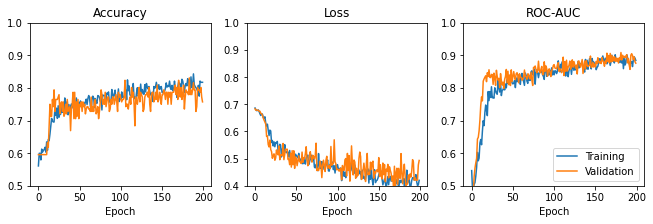

In [12]:
#Plot the results of the train/val process

fig, axs = plt.subplots(1,3, figsize=(11,3))

axs[0].plot(historyLN.history['accuracy'], label='accuracy')
axs[0].plot(historyLN.history['val_accuracy'], label = 'val_accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylim([0.5, 1])

axs[1].plot(historyLN.history['loss'], label='loss')
axs[1].plot(historyLN.history['val_loss'], label = 'val_loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylim([0.4, 1])

axs[2].plot(historyLN.history['auc'], label='Training')
axs[2].plot(historyLN.history['val_auc'], label = 'Validation')
axs[2].set_xlabel('Epoch')
axs[2].set_ylim([0.5, 1])
plt.legend(loc='lower right')

axs[0].set_title('Accuracy')
axs[1].set_title('Loss')
axs[2].set_title('ROC-AUC')

plt.show()

## Test models

First, import and process the test images as before

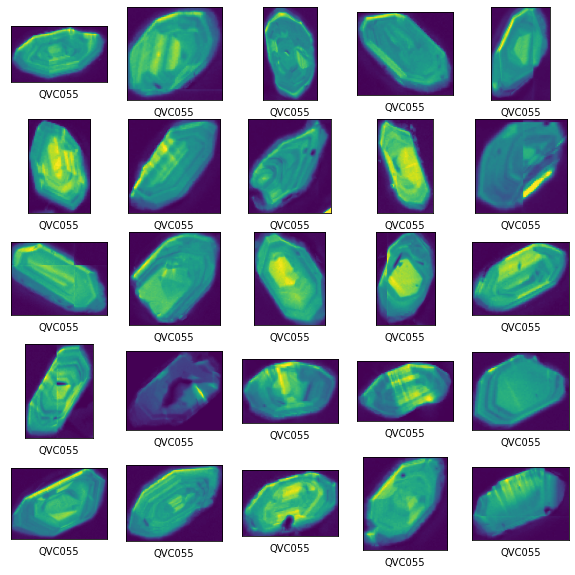

In [13]:
# Test the models

root_dir = 'C:/Users/chen/Desktop/Python_Projects/Zircon_Images/Test_Data2'
y_testing = []
x_testing = []
for filename in glob.iglob(root_dir + '**/*.png', recursive=True):
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    # These images are too large we need to downsize
    canny = cv2.Canny(img, 20, 255, 1)
    kernel = np.ones((4,4),np.uint8)
    dilate = cv2.dilate(canny, kernel, iterations=1)

    # Code from https://stackoverflow.com/questions/56604151/python-extract-multiple-objects-from-image-opencv
    # Find contours
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    image_number = 0
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        # cv2.rectangle(img, (x, y), (x + w, y + h), (36,255,12), 2)
        if w > 40 and h > 40 and w < 90 and h < 90:
            ROI = img[y:y+h, x:x+w]
            x_testing.append(ROI)
            y_testing.append(filename[-10:-4])
            # if image_number % 10 == 0:
            #     cv2.imwrite("ROI_{}.png".format(image_number), ROI)
        image_number += 1

    # cv2.imshow('canny', canny)
    # cv2.imshow('image', img)
    cv2.waitKey(0)
y_testing_samples = y_testing
y_test_zircon = [*map(samples_mapper.get, y_testing)]
    
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_testing[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(y_testing[i])
plt.show()

def convert_to_tensor(n):
    out = tf.convert_to_tensor(n, dtype=None, dtype_hint=None, name=None)
    return out

out = []
for i in x_testing:
    i = tf.convert_to_tensor(i, dtype=None, dtype_hint=None, name=None)
    i = tf.reshape(i, (i.shape[0],i.shape[1],1), name=None) # reshape to be 3D
    i = tf.image.resize_with_crop_or_pad(i, 90,90) # Crop or pad if larger/smaller than 70 pixel long or wide
    i = tf.image.resize(i, [32,32])
    out.append(i)
y_testing = tf.stack(y_test_zircon)
x_test_zircon = tf.stack(out)

# Transfer learning images
out = []
for i in x_testing:
    i = tf.convert_to_tensor(i, dtype=None, dtype_hint=None, name=None)
    i = tf.reshape(i, (i.shape[0],i.shape[1],1), name=None) # reshape to be 3D
    i = tf.image.resize_with_crop_or_pad(i, 90,90) # Crop or pad if larger/smaller than 70 pixel long or wide
    i = tf.image.resize(i, [224,224]) # all images to 32x32
    i = tf.image.grayscale_to_rgb(i, name=None)
    out.append(i)
y_testing = tf.stack(y_test_zircon)
x_test_zircon_TL = tf.stack(out)

# AlexNet images

out = []
for i in x_testing:
    i = tf.convert_to_tensor(i, dtype=None, dtype_hint=None, name=None)
    i = tf.reshape(i, (i.shape[0],i.shape[1],1), name=None) # reshape to be 3D
    i = tf.image.resize_with_crop_or_pad(i, 90,90) # Crop or pad if larger/smaller than 70 pixel long or wide
    i = tf.image.resize(i, [224,224]) # all images to 32x32
    out.append(i)
y_testing = tf.stack(y_test_zircon)
x_test_zircon_alex = tf.stack(out)

71/71 [==============================] - 10s 135ms/step - loss: 0.3983 - accuracy: 0.8592 - auc: 0.9309
test loss, test acc: [0.3983076512813568, 0.8591549396514893, 0.9308695793151855]
71/71 [==============================] - 11s 160ms/step


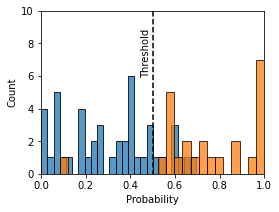

In [16]:
# Transfer learning - import model
TL_VGG_model = tf.keras.models.load_model('C:/Users/chen/Desktop/Python_Projects/Zircon_Images/VGG_TL/')

from tensorflow.keras.applications.vgg16 import preprocess_input

## Preprocessing input
test_ds = preprocess_input(x_test_zircon_TL)
results_vgg = TL_VGG_model.evaluate(test_ds, y_testing, batch_size=1)
print("test loss, test acc:", results_vgg)

predictions =  TL_VGG_model.predict(test_ds, batch_size = 1)

fig, axs = plt.subplots(1,1, figsize = (4,3))
test_results = pd.concat([pd.Series(predictions.flatten()),pd.Series(y_testing)], axis = 1)
test_results.columns = ['Prediction','Real']
sb.histplot(test_results.groupby('Real').get_group(0)['Prediction'], bins = 25, ax  = axs, color = 'tab:blue')
sb.histplot(test_results.groupby('Real').get_group(1)['Prediction'], bins = 25, ax  = axs, color = 'tab:orange')
test_results_VGG = test_results
axs.vlines(0.5, ymin = 10, ymax = 0, color = 'black', linestyle = 'dashed')

axs.set_xlim([0,1])
axs.set_ylim([0,10])
axs.set_xlabel('Probability')
axs.text(0.45,6,'Threshold',rotation=90)
# plt.savefig('220808_VGGTestPredictions.svg', dpi = 1200)
plt.show()

## Feature extraction using UMAP

In [17]:
# Try feature extraction

from tensorflow import keras
from tensorflow.keras.models import Model

trim_model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
trim_model.summary()
features = trim_model.predict(x_train_LN)
features = pd.DataFrame(features)

features_test = pd.DataFrame(trim_model.predict(x_test_zircon))


import umap
data_umap = umap.UMAP(random_state=1, n_components=3).fit_transform(features)
trans = umap.UMAP(random_state=1, n_components=3).fit(pd.concat([features, features_test], axis = 0))
data_umap_test = pd.DataFrame(data = trans.transform(features_test) , columns = ['UMAP1','UMAP2', 'UMAP3'])
data_umap = pd.DataFrame(data =  trans.transform(features), columns = ['UMAP1','UMAP2', 'UMAP3'])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_input (InputLaye  [(None, 32, 32, 1)]      0         
 r)                                                              
                                                                 
 sequential (Sequential)     (None, 32, 32, 1)         0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 6)         60        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        880   

QVC055
QVC075


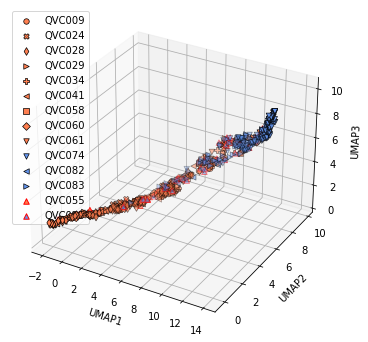

QVC055
QVC075
QVC055
QVC075


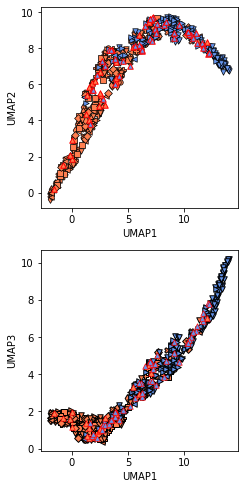

In [18]:
%matplotlib inline

# UMAP1 = crystal shape
# UMAP2 = frequency of zoning
# UMAP3 = intensity of CL response

colour_dict = {'QVC074':'cornflowerblue','QVC075':'cornflowerblue',
               'QVC082':'cornflowerblue','QVC083':'cornflowerblue',
              'QVC028':'coral','QVC058':'coral','QVC009':'coral',
              'QVC034':'coral','QVC024':'coral','QVC060':'coral',
              'QVC061':'coral','QVC055':'coral','QVC029':'coral',
              'QVC041':'coral'}

shape_dict = {'QVC074':'v','QVC075':'^',
               'QVC082':'<','QVC083':'>',
              'QVC028':'d','QVC058':'s','QVC009':'o',
              'QVC034':'P','QVC024':'X','QVC060':'D',
              'QVC061':'v','QVC055':'^','QVC029':'>',
              'QVC041':'<'}

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111, projection='3d')
data_umap2 = pd.concat([pd.Series(y_train_samples, name = 'Samples'), data_umap], axis = 1)
data_umap_test2 = pd.concat([pd.Series(y_testing_samples, name = 'Samples'), data_umap_test], axis = 1)
for name, group in data_umap2.groupby('Samples'):
    ax.scatter(group['UMAP1'],group['UMAP2'], group['UMAP3'],color = colour_dict.get(name), marker = shape_dict.get(name),
               label = name, edgecolor = 'black', linewidth = 0.7, s = 30, depthshade=True)
for name, group in data_umap_test2.groupby('Samples'):
    print(name)
    ax.scatter(group['UMAP1'],group['UMAP2'], group['UMAP3'],color = colour_dict.get(name), marker = shape_dict.get(name),
               label = name, edgecolor = 'red', linewidth = 1, s = 30, depthshade=True)

ax.legend(loc = 2)


ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
plt.rcParams['svg.fonttype'] = 'none'
# plt.savefig('220801_3D_UMAP.svg', dpi = 1200)
plt.show()

fig, axs = plt.subplots(2,1, figsize = (3.5,6.9))

    
for name, group in data_umap2.groupby('Samples'):
    axs[0].scatter(group['UMAP1'],group['UMAP2'],color = colour_dict.get(name), marker = shape_dict.get(name),
               label = name, edgecolor = 'black', linewidth = 0.7, s = 30)
for name, group in data_umap_test2.groupby('Samples'):
    print(name)
    axs[0].scatter(group['UMAP1'],group['UMAP2'],color = colour_dict.get(name), marker = shape_dict.get(name),
               label = name, edgecolor = 'red', linewidth = 1, s = 30)

for name, group in data_umap2.groupby('Samples'):
    axs[1].scatter(group['UMAP1'],group['UMAP3'],color = colour_dict.get(name), marker = shape_dict.get(name),
               label = name, edgecolor = 'black', linewidth = 1, s = 30)

for name, group in data_umap_test2.groupby('Samples'):
    print(name)
    axs[1].scatter(group['UMAP1'],group['UMAP3'],color = colour_dict.get(name), marker = shape_dict.get(name),
               label = name, edgecolor = 'red', linewidth = 0.7, s = 30)

axs[0].set_xlabel('UMAP1')
axs[0].set_ylabel('UMAP2')

axs[1].set_xlabel('UMAP1')
axs[1].set_ylabel('UMAP3')

plt.tight_layout()

plt.show()

## Transfer learning

In [ ]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.4,0.4)),
])

from tensorflow.keras.applications.vgg16 import VGG16

# Import VGG16 from keras
vgg_model = VGG16(include_top=False, input_shape =(224,224,3),  weights = 'imagenet')

#Get the dictionary of config for vgg16
vgg_config = vgg_model.get_config()

# Freeze layers
for layers in (vgg_model.layers)[:13]:
    print(layers)
    layers.trainable = False

inputs = tf.keras.Input(shape=x_train_TL[0].shape)

preprocess_input = tf.keras.applications.vgg16.preprocess_input
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

x = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)(inputs)
x = data_augmentation(inputs)
x = vgg_model(x, training=True)
x = global_average_layer(x)
x = tf.keras.layers.Flatten()(x)  
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
VGG_model = tf.keras.Model(inputs, outputs)
print(VGG_model.summary())

In [ ]:
# Code for early stopping based on threshold
import time
class SOMT(tf.keras.callbacks.Callback):
    def __init__(self, model,  train_thold, valid_thold):
        super(SOMT, self).__init__()
        self.model=model        
        self.train_thold=train_thold
        self.valid_thold=valid_thold
        
    def on_train_begin(self, logs=None):
        print('Starting Training - training will halt if training accuracy achieves or exceeds ', self.train_thold)
        print ('and validation accuracy meets or exceeds ', self.valid_thold) 
        msg='{0:^8s}{1:^12s}{2:^12s}{3:^12s}{4:^12s}{5:^12s}'.format('Epoch', 'Train Acc', 'Train Loss','Valid Acc','Valid_Loss','Duration')
        print (msg)                                                                                    
            
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:1s}processed batch {1:4s}  training accuracy= {2:8.3f}  loss: {3:8.5f}'.format(' ', str(batch),  acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count 
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self,epoch, logs=None): 
        later=time.time()
        duration=later-self.now 
        tacc=logs.get('accuracy')           
        vacc=logs.get('val_accuracy')
        tr_loss=logs.get('loss')
        v_loss=logs.get('val_loss')
        ep=epoch+1
        print(f'{ep:^8.0f} {tacc:^12.2f}{tr_loss:^12.4f}{vacc:^12.2f}{v_loss:^12.4f}{duration:^12.2f}')
        if tacc>= self.train_thold and vacc>= self.valid_thold:
            print( f'\ntraining accuracy and validation accuracy reached the thresholds on epoch {epoch + 1}' )
            self.model.stop_training = True # stop training

train_thold= .95
valid_thold=95
callbacks=[SOMT(VGG_model, train_thold, valid_thold)]


# Train first for 10 epochs with higher learning rate
VGG_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy','AUC'])
history_VGG = VGG_model.fit(x_train_TL, y_train_TL, epochs=200, batch_size = 32,callbacks = callbacks,validation_data=(x_test_TL, y_test_TL))

vgg_model.trainable = True

# Unfreeze last few layers
for layer in vgg_model.layers[:-2]:
    layer.trainable = False


for i,layer in enumerate(VGG_model.get_layer('vgg16').layers):
    print(i,layer.name,layer.trainable)

VGG_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy','AUC'])

VGG_model.summary()

## Visualise outputs of individual convolutional filters

Code from Francois Chollet - Deep Learning with Python (2nd edition)

In [31]:
# Fit a LN model without data augmentation as this appears to cause issues with the code below

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(6, 3, activation='relu',strides = (1,1), padding = 'same', input_shape=(32, 32, 1)))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(18, 3,strides = (1,1), padding = 'same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(32,3,strides = (1,1), padding = 'same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.5)) # Drop out significantly reduces overfitting
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.build(input_shape=(None, 32, 32, 1))
model.summary()

model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy','AUC'])


history = model.fit(x_train_LN, y_train, epochs=100, 
                    validation_data=(x_test_LN, y_test))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 32, 32, 6)         60        
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 18)        990       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 8, 8, 18)         0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 32)          5216      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 4, 4, 32)       

conv_0


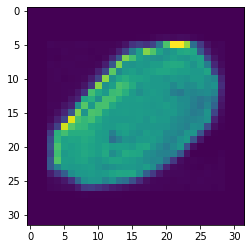

1/1 [==============================] - 0s 40ms/step
(1, 32, 32, 6)
1/1 [==============================] - 0s 38ms/step
(1, 16, 16, 6)
1/1 [==============================] - 0s 51ms/step
(1, 16, 16, 18)
1/1 [==============================] - 0s 48ms/step
(1, 8, 8, 18)
1/1 [==============================] - 0s 56ms/step
(1, 8, 8, 32)
1/1 [==============================] - 0s 61ms/step
(1, 4, 4, 32)


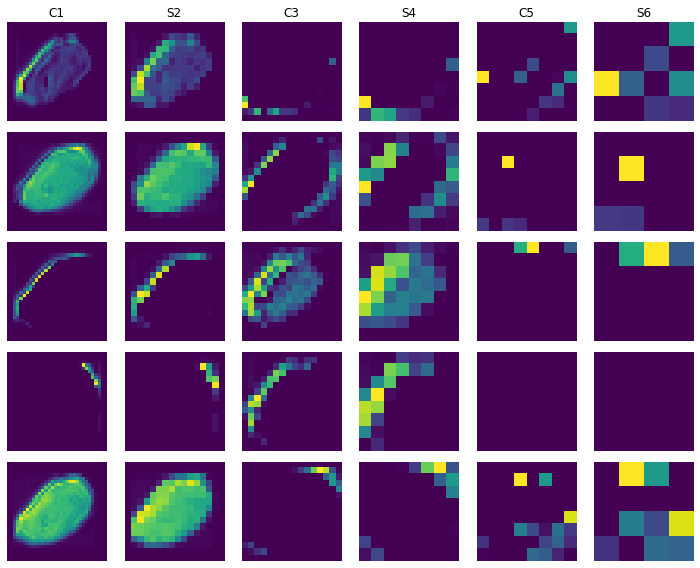

In [32]:
def visualize_conv_layer(layer_name,image):
  
  layer_output=model.get_layer(layer_name).output
  intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output)
  intermediate_model.build(input_shape=(None, 32, 32, 1))

  intermediate_prediction=intermediate_model.predict(tf.reshape(image, (1,32,32,1)))
  
  row_size=3
  col_size=2
  
  img_index=0

  print(np.shape(intermediate_prediction))
  return intermediate_prediction


zircon_to_visualise = x_train[1]
model.layers[0]._name='conv_0'
print(model.layers[0].name)
plt.imshow(zircon_to_visualise)
plt.show()
int_1 = visualize_conv_layer(model.layers[0].name, zircon_to_visualise)
int_2 = visualize_conv_layer(model.layers[1].name, zircon_to_visualise)
int_3 = visualize_conv_layer(model.layers[2].name, zircon_to_visualise)
int_4 = visualize_conv_layer(model.layers[3].name, zircon_to_visualise)
int_5 = visualize_conv_layer(model.layers[4].name, zircon_to_visualise)
int_6 = visualize_conv_layer(model.layers[5].name, zircon_to_visualise)

fig,axs=plt.subplots(5,6,figsize=(10,8))

axs[0,0].imshow(int_1[0, :, :, 0], cmap='viridis')
axs[1,0].imshow(int_1[0, :, :, 1], cmap='viridis')
axs[2,0].imshow(int_1[0, :, :, 2], cmap='viridis')
axs[3,0].imshow(int_1[0, :, :, 3], cmap='viridis')
axs[4,0].imshow(int_1[0, :, :, 5], cmap='viridis')

axs[0,1].imshow(int_2[0, :, :, 0], cmap='viridis')
axs[1,1].imshow(int_2[0, :, :, 1], cmap='viridis')
axs[2,1].imshow(int_2[0, :, :, 2], cmap='viridis')
axs[3,1].imshow(int_2[0, :, :, 3], cmap='viridis')
axs[4,1].imshow(int_2[0, :, :, 5], cmap='viridis')

axs[0,2].imshow(int_3[0, :, :, 0], cmap='viridis')
axs[1,2].imshow(int_3[0, :, :, 1], cmap='viridis')
axs[2,2].imshow(int_3[0, :, :, 2], cmap='viridis')
axs[3,2].imshow(int_3[0, :, :, 3], cmap='viridis')
axs[4,2].imshow(int_3[0, :, :, 5], cmap='viridis')

axs[0,3].imshow(int_4[0, :, :, 0], cmap='viridis')
axs[1,3].imshow(int_4[0, :, :, 1], cmap='viridis')
axs[2,3].imshow(int_4[0, :, :, 2], cmap='viridis')
axs[3,3].imshow(int_4[0, :, :, 3], cmap='viridis')
axs[4,3].imshow(int_4[0, :, :, 5], cmap='viridis')

axs[0,4].imshow(int_5[0, :, :, 0], cmap='viridis')
axs[1,4].imshow(int_5[0, :, :, 1], cmap='viridis')
axs[2,4].imshow(int_5[0, :, :, 2], cmap='viridis')
axs[3,4].imshow(int_5[0, :, :, 3], cmap='viridis')
axs[4,4].imshow(int_5[0, :, :, 5], cmap='viridis')

axs[0,5].imshow(int_6[0, :, :, 0], cmap='viridis')
axs[1,5].imshow(int_6[0, :, :, 1], cmap='viridis')
axs[2,5].imshow(int_6[0, :, :, 2], cmap='viridis')
axs[3,5].imshow(int_6[0, :, :, 3], cmap='viridis')
axs[4,5].imshow(int_6[0, :, :, 5], cmap='viridis')

axr = axs.flatten()
for ax in axr:
    ax.set_axis_off()

axs[0,0].set_title('C1')
axs[0,1].set_title('S2')
axs[0,2].set_title('C3')
axs[0,3].set_title('S4')
axs[0,4].set_title('C5')
axs[0,5].set_title('S6')

plt.tight_layout()
plt.show()